In [5]:
import numpy as np
import pandas as pd
import datetime
import time
import requests
import json
from geopy import distance

import plotly.express as px
import plotly.io as pio
pio.templates[pio.templates.default].layout.colorway = ['#7BA23F','#2D6D4B','#1B813E','#2D6D4B']

#import functions
%run functions.ipynb

import warnings
warnings.filterwarnings('ignore')

In [2]:
r = requests.get('https://tor.publicbikesystem.net/ube/gbfs/v1/en/station_information')

bikeshare_stations = pd.DataFrame(json.loads(r.content)['data']['stations'])[['station_id', 'name', 'lat', 'lon']].astype({
    'station_id': 'string',
})

bikeshare_stations

,station_id,name,lat,lon
0,7000,Fort York Blvd / Capreol Ct,43.639832,-79.395954
1,7001,Wellesley Station Green P,43.664964,-79.383550
2,7002,St. George St / Bloor St W,43.667333,-79.399429
3,7003,Madison Ave / Bloor St W,43.667158,-79.402761
4,7004,University Ave / Elm St,43.656518,-79.389099
...,...,...,...,...
613,7688,High Park Blvd / Parkside Dr,43.644887,-79.456412
614,7689,20 Eaton,43.680012,-79.344033
615,7691,Christie St / Dupont St,43.671656,-79.420727
616,7692,85 Lee Ave,43.670069,-79.297133


In [3]:
for i in range(1, 13):
    if i < 10:
        df_new = pd.read_csv("bike-share-ridership-2021-0"+ str(i) +".csv", encoding='cp1252')
    else:
        df_new = pd.read_csv("bike-share-ridership-2021-"+ str(i) +".csv", encoding='cp1252')
    
    if i == 1:
        df = df_new
    else:
        df = pd.concat([df, df_new])
df        

,Trip Id,Trip Duration,Start Station Id,Start Time,Start Station Name,End Station Id,End Time,End Station Name,Bike Id,User Type,ï»¿Trip Id
0,10644218.0,1315,7021,01/01/2021 00:04,Bay St / Albert St,7164.0,01/01/2021 00:26,Gould St / Yonge St (Ryerson University),6795.0,Annual Member,NaN
1,10644220.0,396,7534,01/01/2021 00:07,Walnut Ave / Queen St W,7524.0,01/01/2021 00:13,Lisgar Park,4176.0,Casual Member,NaN
2,10644221.0,86,7162,01/01/2021 00:10,Hayter St / Laplante Ave,7006.0,01/01/2021 00:11,Bay St / College St (East Side),1814.0,Annual Member,NaN
3,10644222.0,741,7003,01/01/2021 00:10,Madison Ave / Bloor St W,7272.0,01/01/2021 00:22,Yonge St / Dundonald St - SMART,198.0,Casual Member,NaN
4,10644223.0,2073,7562,01/01/2021 00:11,Priscilla Ave / Dundas St W - SMART,7562.0,01/01/2021 00:45,Priscilla Ave / Dundas St W - SMART,6688.0,Casual Member,NaN
...,...,...,...,...,...,...,...,...,...,...,...
145844,NaN,372,7065,12/31/2021 23:56,Dundas St E / Parliament St,7472.0,01/01/2022 00:02,Dundas St E / Victoria St,3487.0,Casual Member,14805103.0
145845,NaN,762,7233,12/31/2021 23:56,King / Cowan Ave - SMART,7569.0,01/01/2022 00:08,Toronto Inukshuk Park,4195.0,Annual Member,14805104.0
145846,NaN,355,7065,12/31/2021 23:56,Dundas St E / Parliament St,7472.0,01/01/2022 00:02,Dundas St E / Victoria St,4574.0,Casual Member,14805105.0
145847,NaN,770,7292,12/31/2021 23:56,Granby St / Church St - SMART,7076.0,01/01/2022 00:09,York St / Queens Quay W,5879.0,Annual Member,14805107.0


## Problematic stations

### Scenario 1: Trip duration is 0
which means that the bike might not be released successfully?

In [4]:
df_station = df[df["Trip  Duration"] == 0]

In [6]:
df_station['Start Time'] = pd.to_datetime(df_station['Start Time'])
df_station['End Time'] = pd.to_datetime(df_station['End Time'])
df_station['Start Station Id'] = df_station['Start Station Id'].astype("string")

In [7]:
df_station

,Trip Id,Trip Duration,Start Station Id,Start Time,Start Station Name,End Station Id,End Time,End Station Name,Bike Id,User Type,ï»¿Trip Id
333,10644662.0,0,7470,2021-01-01 09:41:00,York St / Lake Shore Blvd W,NaN,2021-01-01 09:41:00,NaN,5761.0,Annual Member,NaN
1304,10645786.0,0,7063,2021-01-01 16:00:00,Queen's Park / Bloor St W,NaN,2021-01-01 16:00:00,NaN,6731.0,Annual Member,NaN
1335,10645823.0,0,7419,2021-01-01 16:10:00,Bloor St W / Huron St,NaN,2021-01-01 16:10:00,NaN,6835.0,Casual Member,NaN
1444,10645959.0,0,7281,2021-01-01 16:38:00,Charles St W / Balmuto St - SMART,NaN,2021-01-01 16:38:00,NaN,5748.0,Annual Member,NaN
1933,10646723.0,0,7072,2021-01-02 10:10:00,Fleet St / Bathurst St,7569.0,2021-01-02 10:10:00,Toronto Inukshuk Park,2306.0,Annual Member,NaN
...,...,...,...,...,...,...,...,...,...,...,...
140796,NaN,0,7001,2021-12-30 21:42:00,Wellesley Station Green P,NaN,2021-12-30 21:42:00,NaN,6127.0,Casual Member,14799363.0
141818,NaN,0,7158,2021-12-31 11:20:00,King St W / Stafford St,7524.0,2021-12-31 11:20:00,Lisgar Park,1929.0,Annual Member,14800700.0
142724,NaN,0,7172,2021-12-31 14:01:00,Strachan Ave / Princes' Blvd,7411.0,2021-12-31 14:01:00,Little Norway Park,2642.0,Casual Member,14801688.0
144952,NaN,0,7383,2021-12-31 19:13:00,12 Harbour St,7391.0,2021-12-31 19:13:00,Yonge St / Dundas Sq,2178.0,Casual Member,14804066.0


In [8]:
error_stations = df_station.groupby(["Start Station Id", 
                                     df_station['Start Time'].dt.month])["Trip  Duration"].count().reset_index()

In [9]:
error_stations.columns = ['Start Station Id', 'month', 'count']
error_stations.head(20)

,Start Station Id,month,count
0,7000,1,4
1,7000,4,3
2,7000,6,4
3,7000,7,7
4,7000,8,1
5,7000,9,5
6,7000,10,3
7,7000,11,2
8,7001,3,5
9,7001,5,4


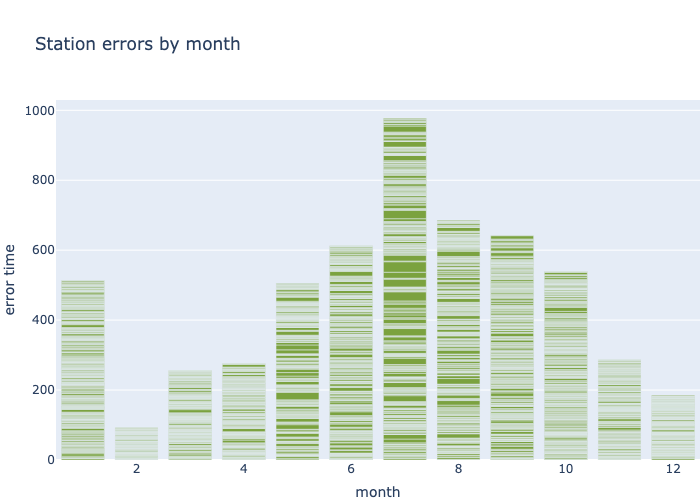

In [23]:
fig = px.bar(error_stations, x='month', y='count', height = 500,
             labels={'Start Station Id':'station ID', 'count':'error time'}, 
             hover_data={'Start Station Id':True},
             title='Station errors by month')

fig.update_layout(margin ={'l':50,'b':0,'r':0})
fig.update_layout(showlegend=False)
#fig.show()
fig.show(renderer="png")
#fig.write_html("visuals/byMon_duration-bar.html")

In [11]:
error_stations = error_stations.merge(bikeshare_stations, how='left', 
                                      left_on='Start Station Id', right_on='station_id')
error_stations = error_stations.sort_values('month', ascending=True)

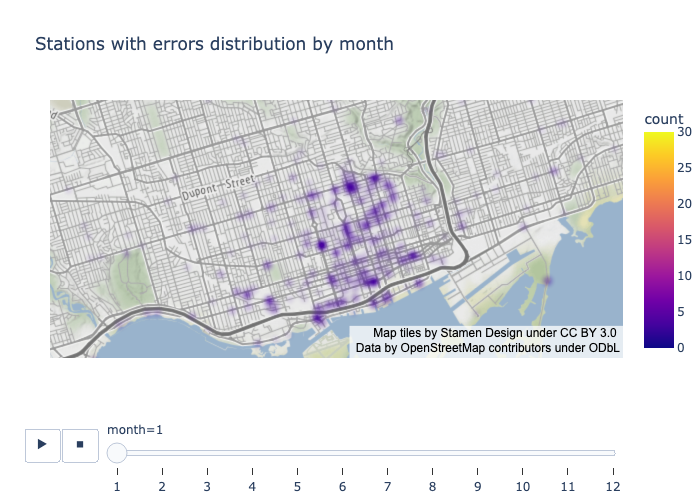

In [24]:
fig = px.density_mapbox(error_stations, lat="lat", lon="lon", 
                        z="count", radius=10, zoom=11,
                        mapbox_style="stamen-terrain",
                        hover_data={'lat':False, 
                                    'lon':False, 
                                    'month':True,
                                    'name':True, 
                                    'count':True
                                    },
                        animation_frame="month",
                        range_color = [0,30],
                        title='Stations with errors distribution by month')

fig.update_layout(margin ={'l':50,'b':0,'r':0})
#fig.show()
fig.show(renderer="png")
#fig.write_html("visuals/popular-pick-up-stations_byMon.html")

In [14]:
error_stations_byMon = error_stations.groupby('month')['count'].count().reset_index()
error_stations_byMon

,month,count
0,1,278
1,2,79
2,3,168
3,4,174
4,5,217
5,6,290
6,7,324
7,8,296
8,9,294
9,10,278


In [15]:
fig = px.bar(error_stations_byMon, x='month', y='count', height = 500,
             title='Station errors by month')

fig.update_layout(margin ={'l':50,'b':0,'r':0})
fig.update_layout(showlegend=False)
fig.show()
#fig.show(renderer="png")
#fig.write_html("visuals/byMon_duration-bar.html")

In [16]:
error_stations_byStation = error_stations.groupby(['Start Station Id'])['count'].sum().reset_index()
error_stations_byStation.sort_values(by="count", ascending = False)

,Start Station Id,count
159,7171,78
378,7430,73
16,7016,69
76,7076,69
186,7203,68
...,...,...
440,7509,1
427,7486,1
424,7483,1
420,7479,1


### Scenario 2: No End station info
and trip duration is not 0; what happened?

In [17]:
df_station_end = df[(df["End Station Id"].isnull()) & (df["Trip  Duration"] != 0)]
df_station_end

,Trip Id,Trip Duration,Start Station Id,Start Time,Start Station Name,End Station Id,End Time,End Station Name,Bike Id,User Type,ï»¿Trip Id
1878,10646666.0,1336,7203,01/02/2021 09:12,Bathurst St/Queens Quay(Billy Bishop Airport),NaN,01/02/2021 09:34,NaN,2598.0,Annual Member,NaN
2087,10646906.0,537,7311,01/02/2021 11:57,Sherbourne St / Isabella St,NaN,01/02/2021 12:06,NaN,3943.0,Casual Member,NaN
2117,10646957.0,1347,7227,01/02/2021 12:17,Martin Goodman Trail (Marilyn Bell Park),NaN,01/02/2021 12:40,NaN,5091.0,Annual Member,NaN
2321,10647173.0,1634,7373,01/02/2021 13:55,George St / King St E,NaN,01/02/2021 14:22,NaN,5152.0,Casual Member,NaN
4337,10649437.0,1330,7021,01/03/2021 13:42,Bay St / Albert St,NaN,01/03/2021 14:04,NaN,5837.0,Casual Member,NaN
...,...,...,...,...,...,...,...,...,...,...,...
273126,NaN,907,7235,10/22/2021 08:36,Bay St / College St (West Side) - SMART,NaN,10/22/2021 08:51,NaN,4487.0,Annual Member,14237811.0
343018,NaN,1680,7075,10/29/2021 07:09,Queens Quay W / Dan Leckie Way,NaN,10/29/2021 07:37,NaN,325.0,Annual Member,14320458.0
95349,NaN,1315,7059,12/17/2021 08:12,Front St W / Blue Jays Way,NaN,12/17/2021 08:34,NaN,2658.0,Annual Member,14745756.0
95665,NaN,1217,7458,12/17/2021 08:55,Church St / Lombard St,NaN,12/17/2021 09:15,NaN,1161.0,Annual Member,14746106.0


In [18]:
df_station_end.groupby("Bike Id").count()

,Trip Id,Trip Duration,Start Station Id,Start Time,Start Station Name,End Station Id,End Time,End Station Name,User Type,ï»¿Trip Id
Bike Id,,,,,,,,,,
59.0,0,1,1,1,1,0,1,0,1,1
175.0,0,1,1,1,1,0,1,0,1,1
239.0,0,1,1,1,1,0,1,0,1,1
325.0,0,1,1,1,1,0,1,0,1,1
357.0,1,1,1,1,1,0,1,0,1,0
...,...,...,...,...,...,...,...,...,...,...
6787.0,1,1,1,1,1,0,1,0,1,0
6795.0,0,1,1,1,1,0,1,0,1,1
6822.0,1,1,1,1,1,0,1,0,1,0


### Scenario 3: No bike info
Something wrong with the stations?

In [19]:
df_bike = df[df["Bike Id"].isnull()]
df_bike

,Trip Id,Trip Duration,Start Station Id,Start Time,Start Station Name,End Station Id,End Time,End Station Name,Bike Id,User Type,ï»¿Trip Id
61,10644283.0,1166,7635,01/01/2021 00:47,Runnymede Rd / Annette St - SMART,7535.0,01/01/2021 01:06,Wolsley St / Palmerston Ave - SMART,NaN,Annual Member,NaN
136,10644377.0,1405,7535,01/01/2021 02:00,Wolsley St / Palmerston Ave - SMART,7100.0,01/01/2021 02:23,Dundas St E / Regent Park Blvd,NaN,Annual Member,NaN
213,10644486.0,1243,7100,01/01/2021 06:33,Dundas St E / Regent Park Blvd,7475.0,01/01/2021 06:54,Jarvis St / Richmond St E,NaN,Annual Member,NaN
271,10644583.0,643,7475,01/01/2021 08:20,Jarvis St / Richmond St E,7533.0,01/01/2021 08:30,Housey St / Dan Leckie Way - SMART,NaN,Annual Member,NaN
391,10644749.0,559,7533,01/01/2021 10:40,Housey St / Dan Leckie Way - SMART,7261.0,01/01/2021 10:50,Queens Quay E / Lower Sherbourne St,NaN,Annual Member,NaN
...,...,...,...,...,...,...,...,...,...,...,...
80682,10741858.0,495,7246,01/29/2021 08:38,Yonge St / Bloor St,7005.0,01/29/2021 08:46,King St W / York St,NaN,Casual Member,NaN
80796,10741985.0,119,7005,01/29/2021 10:04,King St W / York St,7052.0,01/29/2021 10:06,Wellington St W / Bay St,NaN,Casual Member,NaN
81363,10742657.0,842,7052,01/29/2021 15:01,Wellington St W / Bay St,7025.0,01/29/2021 15:15,Ted Rogers Way / Bloor St E,NaN,Casual Member,NaN
81400,10742697.0,1192,7025,01/29/2021 15:16,Ted Rogers Way / Bloor St E,7620.0,01/29/2021 15:35,Eglinton Ave E / Redpath Ave,NaN,Casual Member,NaN


In [20]:
df01 = df[df["Trip  Duration"] != 0]
df01 = df01[df01["End Station Id"].notnull()]
df01 = df01[df01["Bike Id"].notnull()]

In [21]:
df01['Start Time'] = pd.to_datetime(df01['Start Time'])
df01['End Time'] = pd.to_datetime(df01['End Time'])
df01['Trip Id'] = df01['Trip Id'].astype("string")
df01['Start Station Id'] = df01['Start Station Id'].astype("string")
df01['End Station Id'] = df01['End Station Id'].astype("int")
df01['End Station Id'] = df01['End Station Id'].astype("string")
df01['Bike Id'] = df01['Bike Id'].astype("int")
df01['Bike Id'] = df01['Bike Id'].astype("string")

In [22]:
df01["routes"] = df01["Start Station Id"].str.cat("-" + df01["End Station Id"])
routes = df01[['Start Station Id', 'End Station Id', "routes"]].drop_duplicates()
routes = routes.merge(bikeshare_stations, how='inner', left_on='Start Station Id', right_on='station_id') \
       .merge(bikeshare_stations, how='inner', left_on='End Station Id', right_on='station_id', suffixes=['_start', '_end']) \
       .drop_duplicates()
routes['distance'] = routes.apply(lambda x: distance.distance((x['lat_start'], x['lon_start']), (x['lat_end'], x['lon_end'])).m, axis=1)

In [44]:
df01 = df01.merge(routes[['routes', 'distance']], how='left', on='routes')

In [45]:
df01

,Trip Id,Trip Duration,Start Station Id,Start Time,Start Station Name,End Station Id,End Time,End Station Name,Bike Id,User Type,ï»¿Trip Id,routes,distance_x,avg_speed,distance_y
0,10644218.0,1315,7021,2021-01-01 00:04:00,Bay St / Albert St,7164,2021-01-01 00:26:00,Gould St / Yonge St (Ryerson University),6795,Annual Member,NaN,7021-7164,476.553315,0.362398,476.553315
1,10644220.0,396,7534,2021-01-01 00:07:00,Walnut Ave / Queen St W,7524,2021-01-01 00:13:00,Lisgar Park,4176,Casual Member,NaN,7534-7524,1099.138396,2.775602,1099.138396
2,10644221.0,86,7162,2021-01-01 00:10:00,Hayter St / Laplante Ave,7006,2021-01-01 00:11:00,Bay St / College St (East Side),1814,Annual Member,NaN,7162-7006,141.384845,1.644010,141.384845
3,10644222.0,741,7003,2021-01-01 00:10:00,Madison Ave / Bloor St W,7272,2021-01-01 00:22:00,Yonge St / Dundonald St - SMART,198,Casual Member,NaN,7003-7272,1456.774345,1.965957,1456.774345
4,10644223.0,2073,7562,2021-01-01 00:11:00,Priscilla Ave / Dundas St W - SMART,7562,2021-01-01 00:45:00,Priscilla Ave / Dundas St W - SMART,6688,Casual Member,NaN,7562-7562,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3474282,<NA>,372,7065,2021-12-31 23:56:00,Dundas St E / Parliament St,7472,2022-01-01 00:02:00,Dundas St E / Victoria St,3487,Casual Member,14805103.0,7065-7472,1139.289693,3.062607,1139.289693
3474283,<NA>,762,7233,2021-12-31 23:56:00,King / Cowan Ave - SMART,7569,2022-01-01 00:08:00,Toronto Inukshuk Park,4195,Annual Member,14805104.0,7233-7569,1874.712417,2.460253,1874.712417
3474284,<NA>,355,7065,2021-12-31 23:56:00,Dundas St E / Parliament St,7472,2022-01-01 00:02:00,Dundas St E / Victoria St,4574,Casual Member,14805105.0,7065-7472,1139.289693,3.209267,1139.289693
3474285,<NA>,770,7292,2021-12-31 23:56:00,Granby St / Church St - SMART,7076,2022-01-01 00:09:00,York St / Queens Quay W,5879,Annual Member,14805107.0,7292-7076,2372.875659,3.081657,2372.875659


In [51]:
df01["avg_speed"] = df01["distance_x"]/ (df01["Trip  Duration"])
df01

,Trip Id,Trip Duration,Start Station Id,Start Time,Start Station Name,End Station Id,End Time,End Station Name,Bike Id,User Type,ï»¿Trip Id,routes,distance_x,avg_speed,distance_y
0,10644218.0,1315,7021,2021-01-01 00:04:00,Bay St / Albert St,7164,2021-01-01 00:26:00,Gould St / Yonge St (Ryerson University),6795,Annual Member,NaN,7021-7164,476.553315,0.362398,476.553315
1,10644220.0,396,7534,2021-01-01 00:07:00,Walnut Ave / Queen St W,7524,2021-01-01 00:13:00,Lisgar Park,4176,Casual Member,NaN,7534-7524,1099.138396,2.775602,1099.138396
2,10644221.0,86,7162,2021-01-01 00:10:00,Hayter St / Laplante Ave,7006,2021-01-01 00:11:00,Bay St / College St (East Side),1814,Annual Member,NaN,7162-7006,141.384845,1.644010,141.384845
3,10644222.0,741,7003,2021-01-01 00:10:00,Madison Ave / Bloor St W,7272,2021-01-01 00:22:00,Yonge St / Dundonald St - SMART,198,Casual Member,NaN,7003-7272,1456.774345,1.965957,1456.774345
4,10644223.0,2073,7562,2021-01-01 00:11:00,Priscilla Ave / Dundas St W - SMART,7562,2021-01-01 00:45:00,Priscilla Ave / Dundas St W - SMART,6688,Casual Member,NaN,7562-7562,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3474282,<NA>,372,7065,2021-12-31 23:56:00,Dundas St E / Parliament St,7472,2022-01-01 00:02:00,Dundas St E / Victoria St,3487,Casual Member,14805103.0,7065-7472,1139.289693,3.062607,1139.289693
3474283,<NA>,762,7233,2021-12-31 23:56:00,King / Cowan Ave - SMART,7569,2022-01-01 00:08:00,Toronto Inukshuk Park,4195,Annual Member,14805104.0,7233-7569,1874.712417,2.460253,1874.712417
3474284,<NA>,355,7065,2021-12-31 23:56:00,Dundas St E / Parliament St,7472,2022-01-01 00:02:00,Dundas St E / Victoria St,4574,Casual Member,14805105.0,7065-7472,1139.289693,3.209267,1139.289693
3474285,<NA>,770,7292,2021-12-31 23:56:00,Granby St / Church St - SMART,7076,2022-01-01 00:09:00,York St / Queens Quay W,5879,Annual Member,14805107.0,7292-7076,2372.875659,3.081657,2372.875659


In [47]:
df_trouble_2 = df01[df01["distance_x"] == 0]

In [52]:
df_trouble_3 = df01[(df01["avg_speed"] > 30) & (df01["Trip  Duration"] == 2)]

In [53]:
df_trouble = df_trouble_1.append([df_trouble_2, df_trouble_3])
df_trouble

,Trip Id,Trip Duration,Start Station Id,Start Time,Start Station Name,End Station Id,End Time,End Station Name,Bike Id,User Type,ï»¿Trip Id,routes,distance_x,avg_speed,distance_y
61,10644283.0,1166,7635,01/01/2021 00:47,Runnymede Rd / Annette St - SMART,7535.0,01/01/2021 01:06,Wolsley St / Palmerston Ave - SMART,NaN,Annual Member,NaN,<NA>,NaN,NaN,NaN
136,10644377.0,1405,7535,01/01/2021 02:00,Wolsley St / Palmerston Ave - SMART,7100.0,01/01/2021 02:23,Dundas St E / Regent Park Blvd,NaN,Annual Member,NaN,<NA>,NaN,NaN,NaN
213,10644486.0,1243,7100,01/01/2021 06:33,Dundas St E / Regent Park Blvd,7475.0,01/01/2021 06:54,Jarvis St / Richmond St E,NaN,Annual Member,NaN,<NA>,NaN,NaN,NaN
271,10644583.0,643,7475,01/01/2021 08:20,Jarvis St / Richmond St E,7533.0,01/01/2021 08:30,Housey St / Dan Leckie Way - SMART,NaN,Annual Member,NaN,<NA>,NaN,NaN,NaN
333,10644662.0,0,7470,01/01/2021 09:41,York St / Lake Shore Blvd W,NaN,01/01/2021 09:41,NaN,5761.0,Annual Member,NaN,<NA>,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3474265,NaN,113,7252,2021-12-31 23:50:00,Robert St / Bloor St W - SMART,7252,2021-12-31 23:52:00,Robert St / Bloor St W - SMART,2264,Casual Member,14805085.0,7252-7252,0.0,0.0,0.0
3474267,NaN,2403,7030,2021-12-31 23:51:00,Bay St / Wellesley St W,7030,2022-01-01 00:31:00,Bay St / Wellesley St W,3717,Annual Member,14805087.0,7030-7030,0.0,0.0,0.0
3474273,NaN,892,7336,2021-12-31 23:52:00,Queen St E / Alton Av,7336,2022-01-01 00:07:00,Queen St E / Alton Av,4733,Annual Member,14805094.0,7336-7336,0.0,0.0,0.0
3474275,NaN,2987,7252,2021-12-31 23:53:00,Robert St / Bloor St W - SMART,7252,2022-01-01 00:43:00,Robert St / Bloor St W - SMART,5793,Casual Member,14805096.0,7252-7252,0.0,0.0,0.0


In [54]:
df_trouble.groupby(["Start Station Id"])["Start Time"].count()

Start Station Id
7000    32
7001    18
7002    16
7003    15
7004     3
        ..
7683     7
7684     8
7685     1
7686     5
7687     4
Name: Start Time, Length: 1194, dtype: int64

In [55]:
df_trouble.groupby(["Bike Id"])["Start Time"].count()

Bike Id
15.0     1
16.0     1
19.0     1
20.0     2
22.0     2
        ..
994     35
995     31
996     14
997     16
998     15
Name: Start Time, Length: 10052, dtype: int64